# YOLO forward pass in Keras
In this notebook I'm going to try to do a forward pass of a YOLO model in Keras.

In [1]:
import os
import cv2
import csv
import glob
import random
import numpy as np
from tqdm import tqdm_notebook
from keras import backend as K
from keras.models import load_model
from yad2k.models.keras_yolo import yolo_eval, yolo_head

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Define variables 
MODEL_PATH = 'yolo/yolo.h5'
ANCHORS_PATH = 'yolo/yolo_anchors.txt'
CLASSES_PATH = 'yolo/yolo_classes.txt'

In [3]:
# Get tensorflow session
sess = K.get_session() 

In [4]:
# Read classes names
with open(CLASSES_PATH) as f:
    class_names = f.readlines()
    class_names = [c.strip() for c in class_names]

In [5]:
# Read anchors
with open(ANCHORS_PATH) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)

In [6]:
# Load keras model
yolo_model = load_model(MODEL_PATH)

/home/arian/.virtualenvs/deeplearning/lib/python3.5/site-packages/keras/engine/topology.py:1210: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)
/home/arian/.virtualenvs/deeplearning/lib/python3.5/site-packages/keras/models.py:248: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
# Check if model is fully convolutional, assuming channel last order.
model_image_size = yolo_model.layers[0].input_shape[1:3]

In [8]:
# Generate output tensor targets for filtered bounding boxes.
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(
    yolo_outputs,
    input_image_shape,
    score_threshold=0.3,
    iou_threshold=0.5)

In [9]:
# Function for testing a single image from the path 
def test_image(image_file):
    image = cv2.imread(image_file)
    resized_image = cv2.resize(image, model_image_size)
    image_data = np.array(resized_image, dtype='float32')

    image_data /= 255.
    image_data = np.expand_dims(image_data, axis=0) 
    
    out_boxes, out_scores, out_classes = sess.run(
        [boxes, scores, classes],
        feed_dict={
            yolo_model.input: image_data,
            input_image_shape: [image.shape[0], image.shape[1]],
            K.learning_phase(): 0
        })
    
    # print('Found {} boxes for {}'.format(len(out_boxes), image_file))

    data = []
    
    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.shape[0], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.shape[1], np.floor(right + 0.5).astype('int32'))
        
        # print(label, (left, top), (right, bottom))
        
        item = [predicted_class, score, left, top, right, bottom]
        data.append(item)
    
    return data

In [10]:
# Test dir
TEST_PATH = 'images/'

In [11]:
# Test loop
results = {}

image_files = glob.glob(os.path.join(TEST_PATH, '*.jpg'))

for image in tqdm_notebook(image_files):
    results[image] = test_image(image)

In [12]:
results

{'images/test-000190.jpg': [['traffic-sign', 0.36057329, 168, 333, 269, 465]],
 'images/test-003050.jpg': [],
 'images/test-007039.jpg': [['traffic-sign',
   0.86685503,
   1189,
   163,
   1280,
   267]],
 'images/test-011096.jpg': [['traffic-sign',
   0.77298385,
   1217,
   252,
   1280,
   331]],
 'images/test-013983.jpg': [['traffic-sign', 0.80769509, 919, 345, 971, 395]],
 'images/test-015832.jpg': [['traffic-sign', 0.6861189, 884, 300, 926, 349]],
 'images/test-019710.jpg': [['traffic-sign', 0.70576411, 922, 326, 964, 363]],
 'images/test-021032.jpg': [['traffic-sign', 0.81699759, 1021, 310, 1105, 387],
  ['traffic-sign', 0.8298071, 1062, 345, 1144, 416]]}

In [13]:
# Generate colors for each class
colors = plt.cm.hsv(np.linspace(0, 1, len(class_names))).tolist()

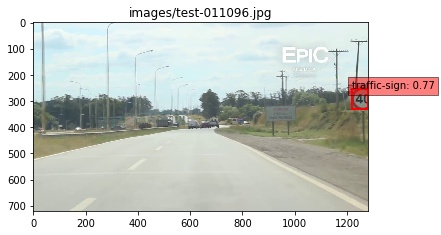

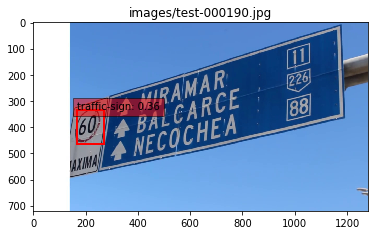

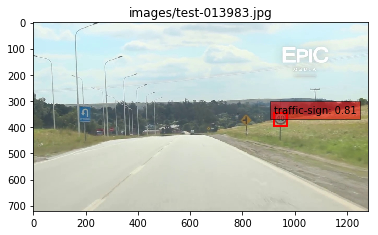

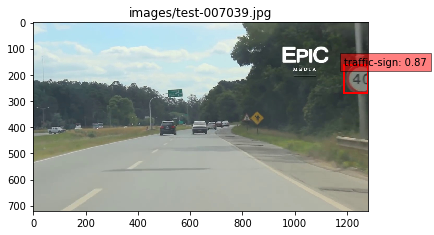

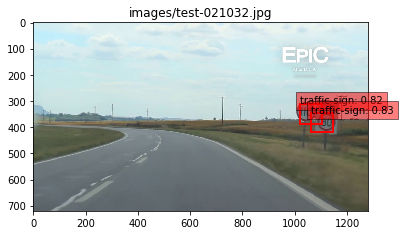

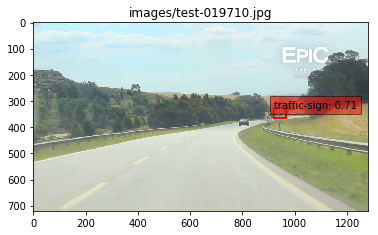

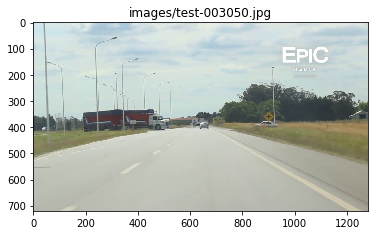

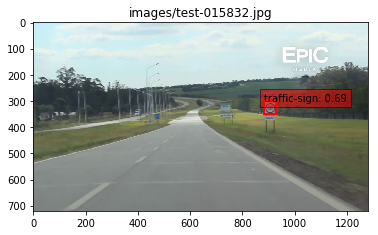

In [14]:
for image in image_files:
    img = cv2.imread(image)
    img = img[...,::-1]
    plt.figure()
    plt.imshow(img)
    plt.title(image)
    currentAxis = plt.gca()

    for i in range(len(results[image])):
        label, score, x1, y1, x2, y2 = results[image][i]
        coords = (x1, y1), x2-x1+1, y2-y1+1
        text = '{}: {:.2f}'.format(label, score)
        
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=colors[class_names.index(label)], linewidth=2))
        currentAxis.text(x1, y1, text, bbox={'facecolor': colors[class_names.index(label)], 'alpha':0.5})
        
plt.show()

### Time YOLO forward pass

In [15]:
import time

results = {}
image_path = image_files[0]

start = time.time()
results[image_path] = test_image(image_path)
end = time.time()

elapsed = end - start

print('YOLO forward pass took {0:.3f} seconds'.format(elapsed))

YOLO forward pass took 0.050 seconds


### Crop traffic sing from YOLO coordinates

In [16]:
x1, y1, x2, y2 = results[image_path][0][2:]
print(x1, y1, x2, y2)

1217 252 1280 331


In [17]:
# Read image
image = cv2.imread(image_path)
crop = image[y1:y2, x1:x2]
crop = crop[...,::-1]

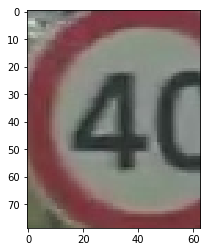

In [18]:
# Plot crop
plt.imshow(crop)
plt.show()

### Run the cropped image through the image classifier

In [19]:
from models.cnn_models import *

In [20]:
# Data path
data_path = 'data/custom/'

# Classes file
classes_file = 'classes.csv'

In [21]:
# Load classes
with open(os.path.join(data_path, classes_file), mode='r') as csv_file:
    reader = csv.reader(csv_file)
    classes = {rows[0]:rows[1] for rows in reader}

In [22]:
# Checkpoint path
checkpoint_path = 'checkpoints/'

# Model name
model_name = 'model_3_custom'

# Model function
model_function = model_3

# Weights path
weights_name = 'model_3_custom-weights-18-1.00.hdf5'
weights_path = os.path.join(os.path.join(checkpoint_path, model_name), weights_name)

In [23]:
model = model_function(weights_path)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 66, 66, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 66, 66, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 34, 34, 64)        0         
__________

In [24]:
crop = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
crop = np.expand_dims(crop, axis=0)
crop.shape

(1, 64, 64, 3)

In [28]:
prediction = model.predict_classes(crop, verbose=False)

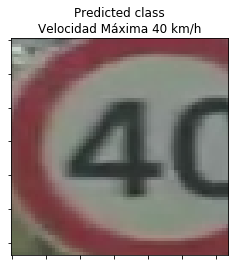

In [34]:
plt.imshow(crop[0])
plt.axes().set_title('Predicted class\n' + classes[str(prediction[0])])
plt.axes().set_yticklabels([])
plt.axes().set_xticklabels([])
plt.show()